## **Name:** Obed
## **Surname:** Majadibodu

# **Dataquest Challenge 2024: Personalised Solutions.**

# 1. Packages.

In [49]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, Dot, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import keras
import seaborn as sns
from sklearn import preprocessing as prep
import pickle

# 2. Dataset overview.
From the description of the given dataset, here is a summary of the main features.
- **User-identifier (idcol):** Unique identifier for each customer.
- **Interaction (interaction):** Types of interactions, including DISPLAY, CLICK, and CHECKOUT.
- **Interaction-date (int_date):** The date of the interaction.
- **Item-identifier (item):** Unique code for each item; NONE if only DISPLAY.
- **Page context (page):** Pages on the app where interactions occur.
- **Time-of-day (tod):** Time slots for interactions: Early, Morning, Afternoon, Evening.
- **Item-type (item_type):** Categories of items: TRANSACT, LEND, INVEST, INSURE, CONNECT, LIFESTYLE.
- **Item-description (item_descrip):** Description of each item.
- **User-segment (segment):** Broad customer segments based on income.
- **Behavioral segment (beh_segment):** Detailed customer segments.
- **Activity indicator (active_ind):** Activity level of customers: Active, Semi Active, Cold Start.

# 3. Load the dataset and display the content.

In [28]:
# Load the dataset
file_path = '/content/drive/MyDrive/dataquest_dataset.csv'
dataquest_data = pd.read_csv(file_path)

# Display the first few rows of the dataset
dataquest_data.head(5)

,idcol,interaction,int_date,item,page,tod,item_type,item_descrip,segment,beh_segment,active_ind
0,755,DISPLAY,17JAN2023,NONE,Screen1,Afternoon,ALL,NaN,segment3,B01,Semi Active
1,4521,DISPLAY,27FEB2023,NONE,Screen1,Afternoon,ALL,NaN,segment1,B07,Semi Active
2,4521,DISPLAY,18FEB2023,NONE,Screen1,Afternoon,ALL,NaN,segment1,B07,Semi Active
3,4521,DISPLAY,30JAN2023,NONE,Screen1,Morning,ALL,NaN,segment1,B07,Semi Active
4,4521,CLICK,05FEB2023,IBAB,Screen1,Afternoon,INSURE,GENERIC MESSAGE,segment1,B07,Semi Active


# 4. Preprocess the dataset.
- Find how many users and features are in the dataset.

In [75]:
dataquest_data.shape

(400000, 13)

- There are 400000 users and 11 features. Let's find how many unique users are in the dataset.

In [76]:
len(dataquest_data["idcol"].unique())

84375

- Statistical data analysis.

In [77]:
dataquest_data.describe()

,idcol,int_date,user_id,item_id
count,4.000000e+05,400000,400000.000000,400000.000000
mean,3.395855e+09,2023-02-13 10:06:13.752000256,42263.446413,1.874362
min,7.550000e+02,2023-01-01 00:00:00,0.000000,0.000000
25%,4.470050e+07,2023-01-22 00:00:00,21480.750000,0.000000
50%,1.145902e+08,2023-02-13 00:00:00,42489.000000,1.000000
75%,3.215196e+08,2023-03-08 00:00:00,62967.000000,4.000000
max,2.572863e+10,2023-03-31 00:00:00,84374.000000,6.000000
std,8.169713e+09,NaN,24094.031570,1.996074


- Identify and calculate the percentage of the missing values in each attribute.

In [78]:
dataquest_data.isnull().sum() / dataquest_data.count() * 100

idcol            0.000000
interaction      0.000000
int_date         0.000000
item             0.000000
page             0.000000
tod              0.000000
item_type        0.000000
item_descrip    76.708105
segment          0.000000
beh_segment      0.000000
active_ind       0.000000
user_id          0.000000
item_id          0.000000
dtype: float64

- Let's check the data types of the columns.

In [79]:
dataquest_data.dtypes

idcol                    int64
interaction             object
int_date        datetime64[ns]
item                    object
page                    object
tod                     object
item_type               object
item_descrip            object
segment                 object
beh_segment             object
active_ind              object
user_id                  int64
item_id                  int64
dtype: object

- More than $76\%$ of values in `item_descrip` is null, so let's drop it.

In [80]:
new_dataquest = dataquest_data.drop('item_descrip', axis=1)
new_dataquest.head(1)

,idcol,interaction,int_date,item,page,tod,item_type,segment,beh_segment,active_ind,user_id,item_id
0,755,DISPLAY,2023-01-17,NONE,Screen1,Afternoon,ALL,segment3,B01,Semi Active,0,0


- Check if there is still NaN values.

In [81]:
new_dataquest.isnull().sum()

idcol          0
interaction    0
int_date       0
item           0
page           0
tod            0
item_type      0
segment        0
beh_segment    0
active_ind     0
user_id        0
item_id        0
dtype: int64

- The number of interactions on each item type.

In [82]:
dataquest_data["item_type"].value_counts()

item_type
ALL          173638
LEND          62036
INSURE        58043
LIFESTYLE     37982
CONNECT       29369
INVEST        22452
TRANSACT      16480
Name: count, dtype: int64

- Number of interactions for users.

In [83]:
dataquest_data["interaction"].value_counts()

interaction
DISPLAY     173638
CLICK       133656
CHECKOUT     92706
Name: count, dtype: int64

- How active the users are.

In [84]:
dataquest_data["active_ind"].value_counts()

active_ind
Active         173842
Semi Active    127275
Cold Start      98883
Name: count, dtype: int64

- Convert interaction date to datetime e.g 17JAN2023 to 2023-01-17. In formating "**%b**" is a month, "**%Y**" is a year, and "**%d**" is a day.

In [85]:
# Convert interaction dates to datetime
dataquest_data['int_date'] = pd.to_datetime(dataquest_data['int_date'], format='%d%b%Y')
dataquest_data.head(5)

,idcol,interaction,int_date,item,page,tod,item_type,item_descrip,segment,beh_segment,active_ind,user_id,item_id
0,755,DISPLAY,2023-01-17,NONE,Screen1,Afternoon,ALL,NaN,segment3,B01,Semi Active,0,0
1,4521,DISPLAY,2023-02-27,NONE,Screen1,Afternoon,ALL,NaN,segment1,B07,Semi Active,1,0
2,4521,DISPLAY,2023-02-18,NONE,Screen1,Afternoon,ALL,NaN,segment1,B07,Semi Active,1,0
3,4521,DISPLAY,2023-01-30,NONE,Screen1,Morning,ALL,NaN,segment1,B07,Semi Active,1,0
4,4521,CLICK,2023-02-05,IBAB,Screen1,Afternoon,INSURE,GENERIC MESSAGE,segment1,B07,Semi Active,1,2


- Encoding of user IDs and item types using LabelEncoder from sklearn.

In [86]:
# Encoding of user IDs and item types.
user_label_encoder, item_label_encoder = LabelEncoder(), LabelEncoder()
dataquest_data['user_id'] = user_label_encoder.fit_transform(dataquest_data['idcol']) # Fit label encoder and return encoded labels.
dataquest_data['item_id'] = item_label_encoder.fit_transform(dataquest_data['item_type']) # Fit label encoder and return encoded labels.
dataquest_data.head(10)

,idcol,interaction,int_date,item,page,tod,item_type,item_descrip,segment,beh_segment,active_ind,user_id,item_id
0,755,DISPLAY,2023-01-17,NONE,Screen1,Afternoon,ALL,NaN,segment3,B01,Semi Active,0,0
1,4521,DISPLAY,2023-02-27,NONE,Screen1,Afternoon,ALL,NaN,segment1,B07,Semi Active,1,0
2,4521,DISPLAY,2023-02-18,NONE,Screen1,Afternoon,ALL,NaN,segment1,B07,Semi Active,1,0
3,4521,DISPLAY,2023-01-30,NONE,Screen1,Morning,ALL,NaN,segment1,B07,Semi Active,1,0
4,4521,CLICK,2023-02-05,IBAB,Screen1,Afternoon,INSURE,GENERIC MESSAGE,segment1,B07,Semi Active,1,2
5,4521,CHECKOUT,2023-02-05,IBAB,Screen1,Afternoon,INSURE,GENERIC MESSAGE,segment1,B07,Semi Active,1,2
6,6145,DISPLAY,2023-02-26,NONE,Screen1,Evening,ALL,NaN,segment3,B01,Cold Start,2,0
7,6145,DISPLAY,2023-01-27,NONE,Screen1,Early,ALL,NaN,segment3,B01,Cold Start,2,0
8,6145,DISPLAY,2023-02-10,NONE,Screen1,Morning,ALL,NaN,segment3,B01,Cold Start,2,0
9,6145,DISPLAY,2023-01-10,NONE,Screen1,Afternoon,ALL,NaN,segment3,B01,Cold Start,2,0


In [87]:
user_label_encoded = user_label_encoder.fit_transform(dataquest_data['idcol'])
print("Encoded user IDs: ", user_label_encoded[:10])
print("Original user IDs: ", user_label_encoder.inverse_transform(user_label_encoded[:10]))
item_label_encoded = item_label_encoder.fit_transform(dataquest_data['item_type'])
print("Encoded item types: ", item_label_encoded[:10])
print("Original item types: ", item_label_encoder.inverse_transform(item_label_encoded[:10]))

Encoded user IDs:  [0 1 1 1 1 1 2 2 2 2]
Original user IDs:  [ 755 4521 4521 4521 4521 4521 6145 6145 6145 6145]
Encoded item types:  [0 0 0 0 2 2 0 0 0 0]
Original item types:  ['ALL' 'ALL' 'ALL' 'ALL' 'INSURE' 'INSURE' 'ALL' 'ALL' 'ALL' 'ALL']


# 5. Exploratory Data Analysis (EDA) with data visualization.
- Let's find out how users are interacting.

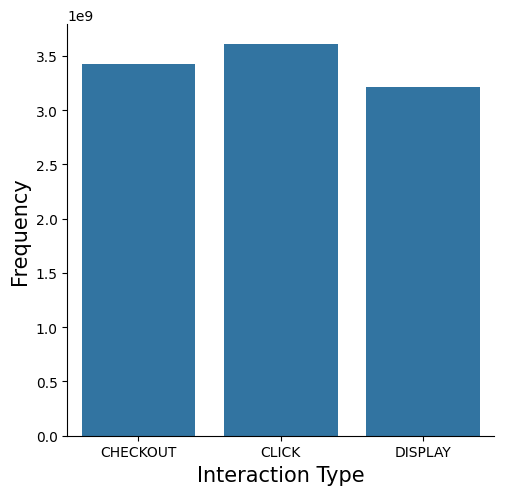

In [88]:
sns.catplot(x='interaction', y='idcol', data=dataquest_data.groupby('interaction')['idcol'].mean().reset_index(), kind='bar')
plt.xlabel('Interaction Type', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

From the bar graph above more users have clicked some items that were displayed to them and more users did checkouts than just displaying.

- Let's find out how users are interacting with each item type.

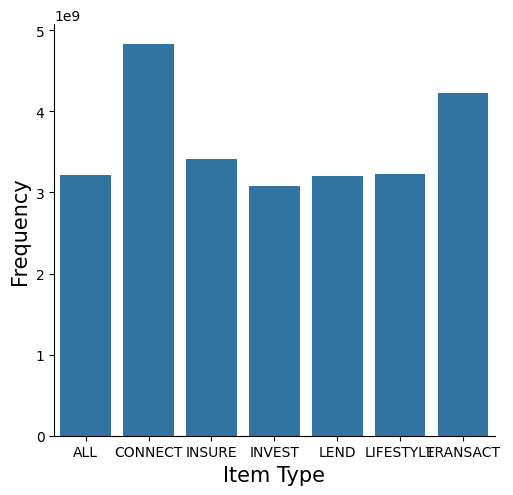

In [89]:
sns.catplot(x='item_type', y='idcol', data=dataquest_data.groupby('item_type')['idcol'].mean().reset_index(), kind='bar')
plt.xlabel('Item Type', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

When there is interactions most users are interacting with the CONNECT item type and least are investing.

- Let's see how active users are.

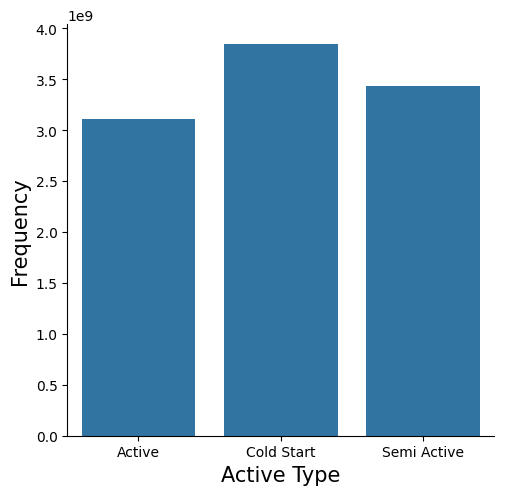

In [90]:
sns.catplot(x='active_ind', y='idcol', data=dataquest_data.groupby('active_ind')['idcol'].mean().reset_index(), kind='bar')
plt.xlabel('Active Type', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

More users are interacting rarely and least are active.

## 6. Collaborative filtering learning algorithm
The collaborative filtering algorithm in the setting of recommending considers a set of $n$-dimensional parameter vectors
$\mathbf{x}^{(0)},...,\mathbf{x}^{(n_i-1)}$, $\mathbf{w}^{(0)},...,\mathbf{w}^{(n_u-1)}$ and $b^{(0)},...,b^{(n_u-1)}$, where the
model predicts the interaction for item $i$ by user $j$ as
$y^{(i,j)} = \mathbf{w}^{(j)}\cdot \mathbf{x}^{(i)} + b^{(j)}$ . Given a dataset that consists of
a set of interactions produced by some users on some items, we wish to
learn the parameter vectors $\mathbf{x}^{(0)},...,\mathbf{x}^{(n_i-1)},
\mathbf{w}^{(0)},...,\mathbf{w}^{(n_u-1)}$  and $b^{(0)},...,b^{(n_u-1)}$ that produce the best fit (minimizes
the squared error).


# 6.1 Collaborative filtering cost function

The collaborative filtering cost function is given by
$$J({\mathbf{x}^{(0)},...,\mathbf{x}^{(n_m-1)},\mathbf{w}^{(0)},b^{(0)},...,\mathbf{w}^{(n_u-1)},b^{(n_u-1)}})= \left[ \frac{1}{2}\sum_{(i,j):r(i,j)=1}(\mathbf{w}^{(j)} \cdot \mathbf{x}^{(i)} + b^{(j)} - y^{(i,j)})^2 \right]
+ \underbrace{\left[
\frac{\lambda}{2}
\sum_{j=0}^{n_u-1}\sum_{k=0}^{n-1}(\mathbf{w}^{(j)}_k)^2
+ \frac{\lambda}{2}\sum_{i=0}^{n_m-1}\sum_{k=0}^{n-1}(\mathbf{x}_k^{(i)})^2
\right]}_{regularization}
\tag{1}$$
The first summation in (1) is "for all $i$, $j$ where $r(i,j)$ equals $1$" and could be written:

$$
= \left[ \frac{1}{2}\sum_{j=0}^{n_u-1} \sum_{i=0}^{n_m-1}r(i,j)*(\mathbf{w}^{(j)} \cdot \mathbf{x}^{(i)} + b^{(j)} - y^{(i,j)})^2 \right]
+\text{regularization}
$$

- Now let's implement the cost function for the collaborative filtering algorithm as above.

In [91]:
# Implemented with vectorization
def collab_filt_cost_fn(X, W, b, Y, R, lambda_):
    j = (tf.linalg.matmul(X, tf.transpose(W)) + b - Y)*R
    J = 0.5 * tf.reduce_sum(j**2) + (lambda_/2) * (tf.reduce_sum(X**2) + tf.reduce_sum(W**2))
    return J

# 7. Create a user-item interaction matrix.
- Create a user-item interaction matrix

In [92]:
# Create a spreadsheet-style pivot table as a DataFrame
interaction_matrix = dataquest_data.pivot_table(index='user_id', columns='item_id', values='interaction', aggfunc='count', fill_value=0)
interaction_matrix.head()

item_id,0,1,2,3,4,5,6
user_id,,,,,,,
0,1,0,0,0,0,0,0
1,3,0,2,0,0,0,0
2,4,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,3,0,0,0,0,0,0


- Let's create **Y** and **R** and other variables.

In [93]:
Y = np.array(interaction_matrix)
print("Y[:3] = \n", Y[:3], "\n")
R = (Y > 0).astype(int)
print("R[:3] = \n", R[:3])

Ynorm = prep.normalize(Y)
num_users, num_items = interaction_matrix.shape[1], interaction_matrix.shape[0]
num_features = 7 # they're 7 items

# Use tensorflow variables as they're fast to create variables X, W, and b.
tf.random.set_seed(4321)
W = tf.Variable(tf.random.normal((num_users, num_features), dtype=tf.float64), name='W')
X = tf.Variable(tf.random.normal((num_items, num_features), dtype=tf.float64), name='X')
b = tf.Variable(tf.random.normal((1, num_users), dtype=tf.float64), name='b')
# Choose Adam optimizer
adam_optimizer = keras.optimizers.Adam(learning_rate=0.1)

Y[:3] = 
 [[1 0 0 0 0 0 0]
 [3 0 2 0 0 0 0]
 [4 0 0 0 0 0 0]] 

R[:3] = 
 [[1 0 0 0 0 0 0]
 [1 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]]


- We will train the collaborative filtering model to learn the parameters $X$, $W$, and $b$.

# 8. Training the learning algorithm.

In [69]:
iterations = 200
lambda_ = 1
costs = []
for iter in range(iterations):
    with tf.GradientTape() as tape:

        # Compute the total cost.
        total_cost = collab_filt_cost_fn(X, W, b, Ynorm, R, lambda_)
        costs.append(total_cost)

    gradients = tape.gradient(total_cost, [X,W,b])

    # Run gradient descent.
    adam_optimizer.apply_gradients(zip(gradients, [X,W,b]))

    # Print training loss after every 10 iterations.
    if iter % 10 == 0:
        print(f"Training loss at iteration {iter}: {total_cost:0.1f}")

Training loss at iteration 0: 1182.9
Training loss at iteration 10: 1025.5
Training loss at iteration 20: 915.3
Training loss at iteration 30: 834.5
Training loss at iteration 40: 772.5
Training loss at iteration 50: 723.0
Training loss at iteration 60: 682.3
Training loss at iteration 70: 648.0
Training loss at iteration 80: 618.6
Training loss at iteration 90: 593.1
Training loss at iteration 100: 570.8
Training loss at iteration 110: 551.2
Training loss at iteration 120: 533.5
Training loss at iteration 130: 517.4
Training loss at iteration 140: 503.0
Training loss at iteration 150: 489.9
Training loss at iteration 160: 477.8
Training loss at iteration 170: 466.9
Training loss at iteration 180: 457.2
Training loss at iteration 190: 447.8


# 9. Recommendations.

In [70]:
preds = np.matmul(X.numpy(), np.transpose(W.numpy())) + b.numpy()

for i in range(preds.shape[0])[:10]:
  for j in range(preds.shape[1]):
    if Y[i, j] != 0:
      print("For user", user_label_encoder.inverse_transform([i]), "predicted", preds[i, j], "for ", Y[i, j], " which is ", item_label_encoder.inverse_transform([Y[i, j]]))

For user [755] predicted 0.9856296131223339 for  1  which is  ['CONNECT']
For user [4521] predicted 0.8291877037606035 for  3  which is  ['INVEST']
For user [4521] predicted 0.5561381543806864 for  2  which is  ['INSURE']
For user [6145] predicted 0.9854940303330029 for  4  which is  ['LEND']
For user [7125] predicted 0.9836528358762904 for  1  which is  ['CONNECT']
For user [8469] predicted 0.9856881178684818 for  3  which is  ['INVEST']
For user [13768] predicted 0.983747360073082 for  1  which is  ['CONNECT']
For user [14454] predicted 0.47880500028440853 for  1  which is  ['CONNECT']
For user [14454] predicted 0.8698465568222195 for  2  which is  ['INSURE']
For user [15000] predicted 0.46292424927467407 for  1  which is  ['CONNECT']
For user [15000] predicted 0.8689873345866819 for  2  which is  ['INSURE']
For user [15784] predicted 0.983942068990272 for  1  which is  ['CONNECT']
For user [22210] predicted 0.985564870937551 for  2  which is  ['INSURE']


- Define a function to store leaned X, W, and b.

In [71]:
def model_params(X, W, Y):
  return X, W, Y

# 10. Persist the model.

In [74]:
# Saving the model using pickel
model_parameters = model_params(X, W, Y)
recommender = "collaborative_recommender.pkl"
with open(recommender, 'wb') as file:
    pickle.dump(model_parameters, file)